### MultiClass Text Classification
#### Target ~ Text input
A gently guideline to handle real data

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import pickle

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SpanishStemmer

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
#!pip install stop_words
from stop_words import get_stop_words

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing


#!python -m spacy download es
import es_core_news_sm  #es_core_news_md
from spacy import displacy
from spacy.tokenizer import Tokenizer

import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

#### Loading data

In [2]:
resource_path = 'release3/resources'

In [3]:
df = pd.read_excel('path/to/corpus.xlsx', sheet_name='Hoja1')
print('Data size: ', df.shape)

# General Model resources
stopSpanish = pickle.load(open(f"{resource_path}/stopSpanish.pkl",'rb'))
id_to_category = pickle.load(open(f"{resource_path}/id_to_category.pkl",'rb'))
tfidf_legacy = pickle.load(open(f"{resource_path}/tfidf_legacy.pkl",'rb'))
model_legacy = pickle.load(open(f"{resource_path}/model_legacy.pkl",'rb'))
onehot_encoder_legacy = pickle.load(open(f"{resource_path}/onehot_encoder_legacy.pkl",'rb'))

# Model of overlaped classes
id_to_category_sub = pickle.load(open("release3/resources/id_to_category_sub.pkl",'rb'))
tfidf_sub = pickle.load(open("release3/resources/tfidf_sub.pkl",'rb'))
onehot_encoder_sub = pickle.load(open("release3/resources/onehot_encoder_sub.pkl",'rb'))
model_sub = pickle.load(open("release3/resources/model_sub.pkl",'rb'))

Data size:  (10948, 19)


### Exploratory analysis

Removing non useful variables

In [4]:
df = remove_variables(df)
print('Data size: ', df.shape)

Data size:  (10871, 6)


Target distribution

In [ ]:
plot_freq_target_comentario(df, 'TARGET')

Removing class with lowest samples

In [ ]:
df = remove_rows(df, 'TARGET', 'NON_REPRESENTATIVE_CATEGORY')

Text normalization

In [7]:
df['TEXTINPUT'] = df['TEXTINPUT'].map(lambda com : remove_stopwords(clean_text(com), stopSpanish))

Categories handling (from text to id)

In [8]:
category_id_df, id_to_category, df = target_handling(df,'TARGET','category_to_id.pkl','id_to_category.pkl')

Saving target categories


### Data preparation

Feature text to numeric vector

In [12]:
# Run this cell if 'tfidf_legacy' not present

# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words=stopSpanish)
# features = tfidf.fit_transform(df.TEXTINPUT).toarray()

# # For relevant features extraction
# X = tfidf.fit_transform(df.TEXTINPUT)
# feature_names = tfidf.get_feature_names()

# print("Saving Tf-idf Vectorizer:")
# with open(f'{resource_path}/tfidf_mixed_m1.pkl', 'wb') as f:
#     pickle.dump(tfidf, f)

In [10]:
labels = df.TARGET_id

One hot encoding of categorical variables

Legacy model - no training required

In [11]:
features = tfidf_legacy.transform(df.TEXTINPUT).toarray()
one_hot = onehot_encoder_legacy.transform(np.array(df[['CATEGORYCOLUMN']]))

#### Relevant features

Plot most relevant words by class

In [15]:
topfeats = top_feats_by_class(X, labels, feature_names)

In [ ]:
plot_tfidf_classfeats_h(topfeats, id_to_category_tmp)

Merge vectorized features, category features and aditional features

In [12]:
features = np.append(features, one_hot, axis=1)

In [13]:
features.shape

(10866, 17281)

### Training models

In [ ]:
# Models
models = [
    RandomForestClassifier(n_estimators=300, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr'),
]

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/main/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


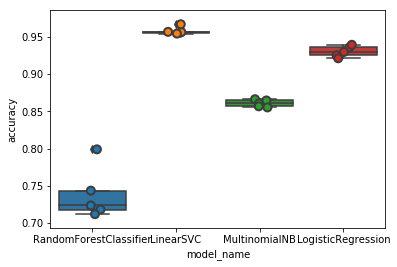

In [20]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Model evaluation

In [21]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.957941
LogisticRegression        0.930233
MultinomialNB             0.860660
RandomForestClassifier    0.739146
Name: accuracy, dtype: float64

In [20]:
# Individual model training

model = LinearSVC(max_iter=10000)
#model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='ovr')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# clf = CalibratedClassifierCV(base_estimator=model, cv='prefit') 
# clf.fit(X_train, y_train)
# y_proba = clf.predict_proba(X_test)

accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)

print('accuracies (individual model)',accuracies)

accuracies (individual model) [0.95737705 0.95209974 0.94806049 0.95720869 0.95912986]


In [14]:
#No training required
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.3, random_state=42)
y_pred = model_legacy.predict(X_test)

# clf = CalibratedClassifierCV(base_estimator=model, cv='prefit') 
# clf.fit(X_train, y_train)
# y_proba = clf.predict_proba(X_test)

accuracies = cross_val_score(model_legacy, X_train, y_train, scoring='accuracy', cv=CV)

print('accuracies (individual model)',accuracies)

accuracies (individual model) [0.8642623  0.84776903 0.84888305 0.84924292 0.85883905]


In [ ]:
# Result - Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.TEXTINPUT.values, yticklabels=category_id_df.TARGET.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print("Summary of model by classes:")
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['TARGET'].unique()))

In [ ]:
dft = df.loc[list(indices_test)].copy()
dft['TARGET_id_pred'] = y_pred
dft.head()

#### Sub classifier

In [25]:
y_pred_sub = []
for i in dft[(dft['TARGET_id_pred'] == 2) | (dft['TARGET_id_pred'] == 8)].index:
    features_sub = tfidf_sub.transform([dft.TEXTINPUT[i]]).toarray()
    one_hot_sub = onehot_encoder_sub.transform(np.array([dft.CATEGORYCOLUMN[i],..,]).reshape(1, 3))
    features_sub = np.append(features_sub, one_hot_sub, axis=1)
    sub_pred = model_sub.predict(features_sub)[0]
    #print(sub_pred.item())
    y_pred_sub.append(sub_pred)

In [29]:
y_pred_sub = [2 if x==0 else 8 for x in y_pred_sub]

In [32]:
dft.loc[(dft['TARGET_id_pred'] == 2) | (dft['TARGET_id_pred'] == 8), 'TARGET_id_pred'] = y_pred_sub

New y_test and y_pred

In [35]:
y_test_n = dft.TARGET_id
y_pred_n = dft.TARGET_id_pred

In [ ]:
# Result - Confusion matrix
conf_mat = confusion_matrix(y_test_n, y_pred_n)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.TARGET.values, yticklabels=category_id_df.TARGET.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print("Summary of model by classes:")
print(metrics.classification_report(y_test_n, y_pred_n, 
                                    target_names=df['TARGET'].unique()))